In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
sample_image = np.load('data/train/image/0.npy')
sample_mask = np.load('data/train/label/0.npy')

In [56]:
test = sample_image[:,64:-64]

In [57]:
test.shape

(128, 128, 3)

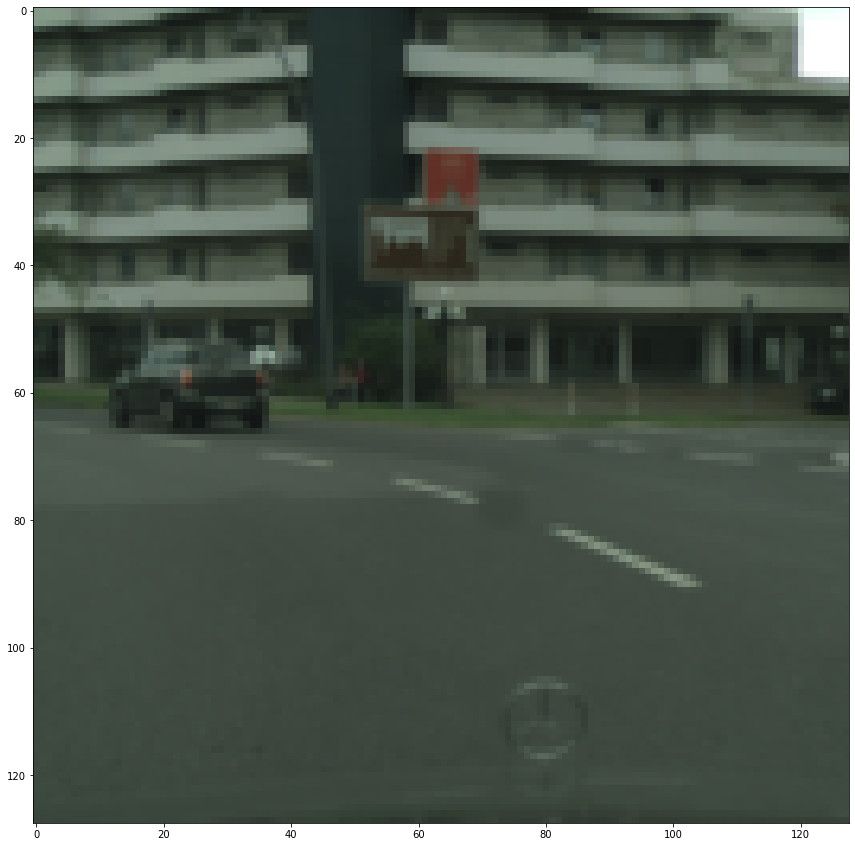

In [55]:
# plot two image and mask overlayed
plt.figure(figsize=(15, 15))
plt.imshow(sample_image[:,64:-64])
# plt.imshow(sample_mask, alpha=0.5)
plt.show()

In [22]:
import os

In [74]:
images_paths = os.listdir('data/train/image')
# sort the paths
images_paths.sort()

masks_paths = os.listdir('data/train/label')
# sort the paths
masks_paths.sort()

In [75]:
images = []
for f in images_paths:
    if f.endswith('.npy'):
        images.append(np.load('data/train/image/' + f))

images = np.array(images)

In [76]:
masks = []
for f in masks_paths:
    if f.endswith('.npy'):
        masks.append(np.load('data/train/label/' + f))

masks = np.array(masks)

In [71]:
images.shape

(2975, 128, 256, 3)

In [72]:
masks.shape

(2975, 128, 256)

In [62]:
images[0]

array([[[0.51372549, 0.6       , 0.53333333],
        [0.52156863, 0.60392157, 0.53333333],
        [0.5254902 , 0.60784314, 0.5372549 ],
        ...,
        [0.93333333, 1.        , 0.98431373],
        [0.94117647, 1.        , 0.98823529],
        [0.94901961, 1.        , 0.99215686]],

       [[0.52156863, 0.6       , 0.53333333],
        [0.52156863, 0.6       , 0.53333333],
        [0.52156863, 0.60784314, 0.5372549 ],
        ...,
        [0.96862745, 1.        , 0.99607843],
        [0.97647059, 1.        , 0.99607843],
        [0.98823529, 1.        , 1.        ]],

       [[0.50588235, 0.58823529, 0.5254902 ],
        [0.49411765, 0.57647059, 0.51372549],
        [0.47843137, 0.56470588, 0.49803922],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[0.23137255, 0.28235294, 0.23921569],
        [0.23137255, 0.28235294, 0.23921569],
        [0.23137255, 0

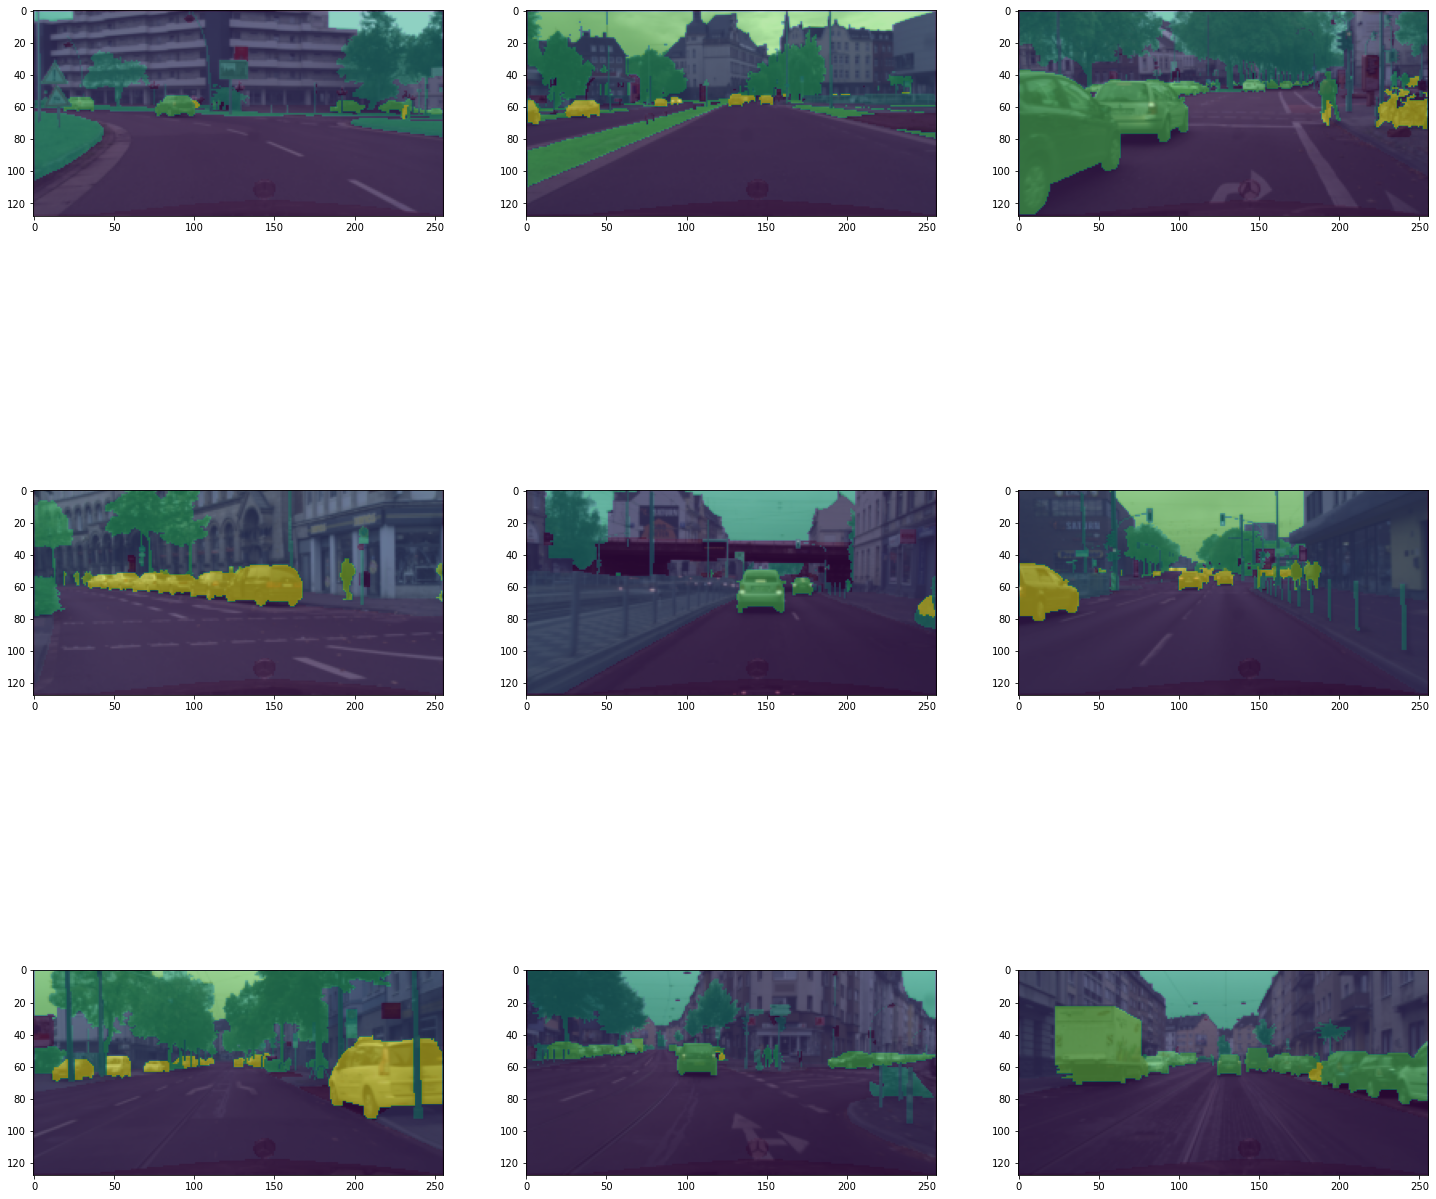

In [78]:
# Plot 9 images and masks
plt.figure(figsize=(25, 25))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.imshow(masks[i], alpha=0.5)

plt.show()

In [95]:
import tensorflow as tf

In [100]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 128
OUTPUT_CHANNELS = 3

In [101]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [104]:
masks.shape

(2975, 128, 256)

In [111]:
expanded_masks = np.expand_dims(masks, axis=-1)
expanded_masks.shape

(2975, 128, 256, 1)

In [112]:
down_model = downsample(3, 4)
down_result = down_model(expanded_masks)
print (down_result.shape)

(2975, 64, 128, 3)


In [113]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [114]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(2975, 128, 256, 3)


In [124]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [125]:
generator = Generator()
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 2, 2, 512), (None, 1, 1, 512)]

In [122]:
gen_output = generator(masks[0:1], training=False)
# plt.imshow(gen_output[0, ...])

ValueError: Input 0 of layer "model_14" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(1, 128, 256)